In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy

In [17]:
cols = [#'bayesian_prediction_std_bal_acc',
        #'bayesian_prediction_std_f1_score', 
        #'bayesian_prediction_std_auc',
        'epochs',
        'bayesian_entropy__bal_acc', 
        #'bayesian_entropy_f1_score',
        'bayesian_entropy__auc']

In [18]:
experiments = ['bayesian', 'mlp_dropout', 'poor_bayesian', 'mlp_deterministic']

In [19]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_uncertainty_with_unknown.csv')
    df_with_results = df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_uncertainty_without_unknown.csv')
    df_without_results = df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [20]:
results_cols = ['inside', 'outside',
                'in_epochs', 'out_epochs',
                'in_entropy_acc', 'out_entropy_acc',
                'in_entropy_auc', 'out_entropy_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            in_key[0], in_key[1],
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
        ]
    dfs_results.append([exp, results])

In [21]:
final_results_cols = ['inside', 'outside']
for c in results_cols[2:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [22]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row  in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        assert prev_row[1] == row[1]
        
    _, *row = key_row[0]
    new_row = [row[0], row[1]]
    
    for c in range(2, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [23]:
final_results.columns

Index(['inside', 'outside', 'bayesian_in_epochs', 'mlp_dropout_in_epochs',
       'poor_bayesian_in_epochs', 'mlp_deterministic_in_epochs',
       'bayesian_out_epochs', 'mlp_dropout_out_epochs',
       'poor_bayesian_out_epochs', 'mlp_deterministic_out_epochs',
       'bayesian_in_entropy_acc', 'mlp_dropout_in_entropy_acc',
       'poor_bayesian_in_entropy_acc', 'mlp_deterministic_in_entropy_acc',
       'bayesian_out_entropy_acc', 'mlp_dropout_out_entropy_acc',
       'poor_bayesian_out_entropy_acc', 'mlp_deterministic_out_entropy_acc',
       'bayesian_in_entropy_auc', 'mlp_dropout_in_entropy_auc',
       'poor_bayesian_in_entropy_auc', 'mlp_deterministic_in_entropy_auc',
       'bayesian_out_entropy_auc', 'mlp_dropout_out_entropy_auc',
       'poor_bayesian_out_entropy_auc', 'mlp_deterministic_out_entropy_auc'],
      dtype='object')

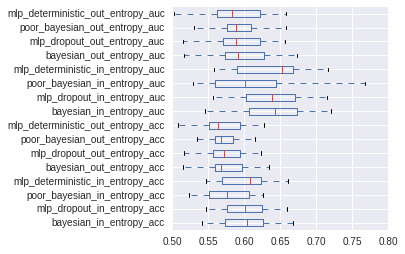

In [24]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 10)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[10:])
plt.subplots_adjust(left=0.4)

In [25]:
code = '''
data {
    int K; // Number of groups
    int N; // Number of examples per group
    real y[N, K]; // Observations 
}
parameters {
    real mu; // Mean
    vector[K-1] theta_free; // Effects
    real<lower=0> sigma_likelihood; // Noise std
    real<lower=0> sigma_theta; // Effect std
}
transformed parameters {
  vector[K] theta; // Effects with sum to zero constraint

  for(k in 1:(K-1)) theta[k] <- theta_free[k];
  theta[K] <- -sum(theta_free);
}
model {
    sigma_theta ~ cauchy(0, 25);
    theta_free ~ normal(0, sigma_theta); // Weak effect prior

    mu ~ normal(0, 100); // Weak mean prior
    sigma_likelihood ~ uniform(0, 100); // Weak noise std prior
    
    for (i in 1:N)
        for (j in 1:K)
            y[i][j] ~ normal(mu + theta[j], sigma_likelihood); // Normal likelihood
}
'''

model = pystan.StanModel(model_code=code)

In [34]:
out_acc = ['mlp_deterministic_out_entropy_acc', 'mlp_dropout_out_entropy_acc', 'poor_bayesian_out_entropy_acc', 'bayesian_out_entropy_acc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['mlp_deterministic_in_entropy_acc', 'mlp_dropout_in_entropy_acc', 'poor_bayesian_in_entropy_acc', 'bayesian_in_entropy_acc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

In [35]:
y = y_in
(N, K) = y.shape

data = {'K': K, 'N': N, 'y': y}
fit = model.sampling(data=data, iter=1000, chains=4)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_b783e10962b52822c45419e8044d4406.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                  0.4  4.7e-4   0.02   0.36   0.39    0.4   0.42   0.44   2000   1.01
theta_free[0]    5.1e-3  5.7e-4   0.03  -0.04-9.1e-3 2.8e-3   0.02   0.06   2000   1.01
theta_free[1]      0.01  6.1e-4   0.03  -0.03-3.0e-3   0.01   0.03   0.08   2000   1.01
theta_free[2]     -0.04  7.9e-4   0.04  -0.12  -0.06  -0.04  -0.01 9.3e-3   2000   1.01
sigma_likelihood   0.18  3.2e-4   0.01   0.15   0.17   0.18   0.19   0.21   2000    1.0
sigma_theta        0.07  1.8e-3   0.08 5.6e-3   0.02   0.04   0.08   0.27   2000    1.0
theta[0]         5.1e-3  5.7e-4   0.03  -0.04-9.1e-3 2.8e-3   0.02   0.06   2000   1.01
theta[1]           0.01  6.1e-4   0.03  -0.03-3.0e-3   0.01   0.03   0.08   2000   1.01
theta[2]          -0.

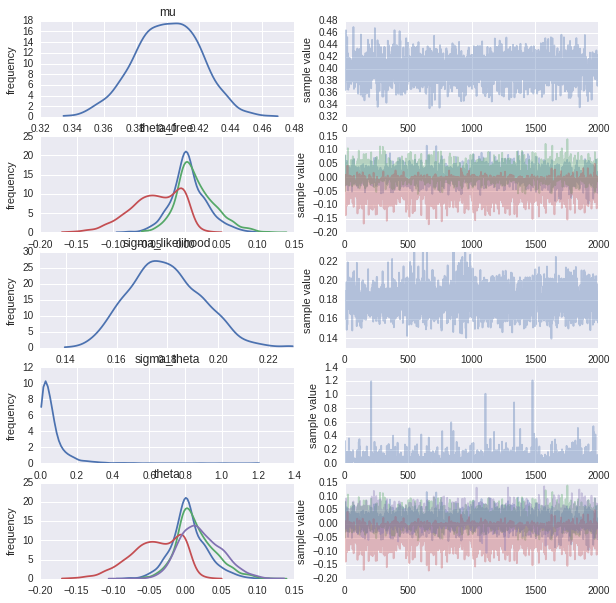

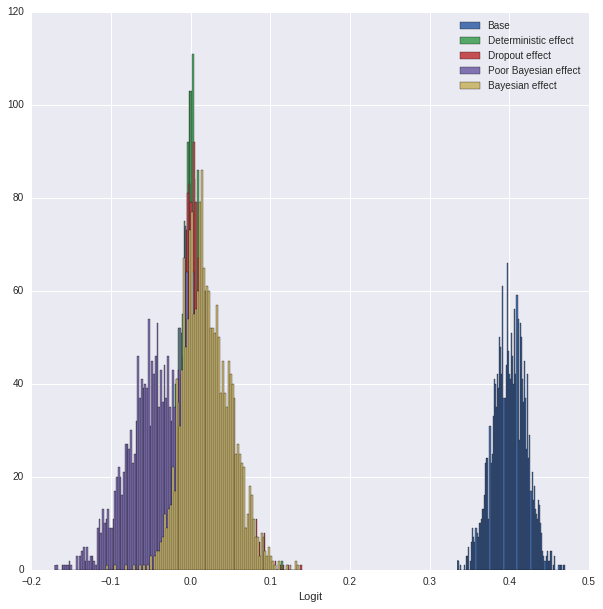

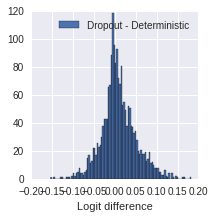

Dropout - Deterministic 95.0 CI: -0.0679669476412 0.0992599097567 Pr > 0: 0.567


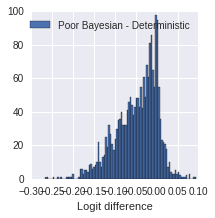

Poor Bayesian - Deterministic 95.0 CI: -0.158022368626 0.0257613671551 Pr > 0: 0.167


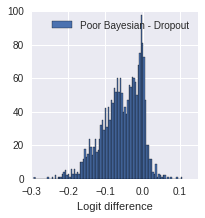

Poor Bayesian - Dropout 95.0 CI: -0.170184444697 0.0190821871292 Pr > 0: 0.1255


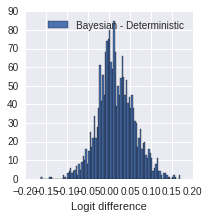

Bayesian - Deterministic 95.0 CI: -0.068062461556 0.106754046482 Pr > 0: 0.634


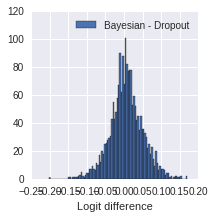

Bayesian - Dropout 95.0 CI: -0.0845752651827 0.0969316687965 Pr > 0: 0.5655


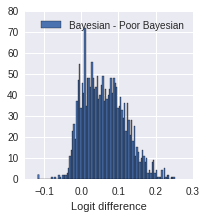

Bayesian - Poor Bayesian 95.0 CI: -0.023207182617 0.182918770714 Pr > 0: 0.8585


In [36]:
print(fit)
fit.plot()
trace = fit.extract()

deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]
bayesian = trace['theta'][:,3]

plt.figure()
plt.hist(trace['mu'], bins = 100, label = 'Base')
plt.hist(deterministic, bins = 100, label = 'Deterministic effect')
plt.hist(dropout, bins = 100, label = 'Dropout effect')
plt.hist(poor_bayesian, bins = 100, label = 'Poor Bayesian effect')
plt.hist(bayesian, bins = 100, label = 'Bayesian effect')
plt.legend()
plt.xlabel("Logit")
plt.show()

def effect_difference(effect1, effect2, name1, name2, CI = 95.0):
    diff = effect1 - effect2
    label = str(name1) + ' - ' + str(name2)
    plt.figure(figsize=(5,5))
    plt.hist(diff, bins = 100, label = label)
    plt.legend()
    plt.xlabel("Logit difference")
    plt.show()
    low_p = (100.0 - CI)/2.0
    high_p = low_p + CI
    print(label, str(CI) + ' CI:', np.percentile(diff, low_p), np.percentile(diff, high_p), 'Pr > 0:', (diff > 0).mean())

effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')
effect_difference(bayesian, deterministic, 'Bayesian', 'Deterministic')
effect_difference(bayesian, dropout, 'Bayesian', 'Dropout')
effect_difference(bayesian, poor_bayesian, 'Bayesian', 'Poor Bayesian')

In [37]:
y = y_out
(N, K) = y.shape

data = {'K': K, 'N': N, 'y': y}
fit = model.sampling(data=data, iter=1000, chains=4)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_b783e10962b52822c45419e8044d4406.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 0.29  3.0e-4   0.01   0.27   0.28   0.29    0.3   0.32   2000    1.0
theta_free[0]   -3.7e-3  3.0e-4   0.01  -0.04  -0.01-1.8e-3 3.3e-3   0.02   2000    1.0
theta_free[1]   -8.9e-5  3.0e-4   0.01  -0.03-6.7e-3-2.3e-4 6.3e-3   0.03   2000    1.0
theta_free[2]   -1.8e-3  2.9e-4   0.01  -0.03-8.3e-3-1.2e-3 4.3e-3   0.03   2000    1.0
sigma_likelihood   0.12  2.4e-4   0.01    0.1   0.11   0.12   0.12   0.14   2000   1.01
sigma_theta        0.02  1.5e-3   0.07 2.3e-3 6.6e-3   0.01   0.03   0.09   2000    1.0
theta[0]        -3.7e-3  3.0e-4   0.01  -0.04  -0.01-1.8e-3 3.3e-3   0.02   2000    1.0
theta[1]        -8.9e-5  3.0e-4   0.01  -0.03-6.7e-3-2.3e-4 6.3e-3   0.03   2000    1.0
theta[2]        -1.8e

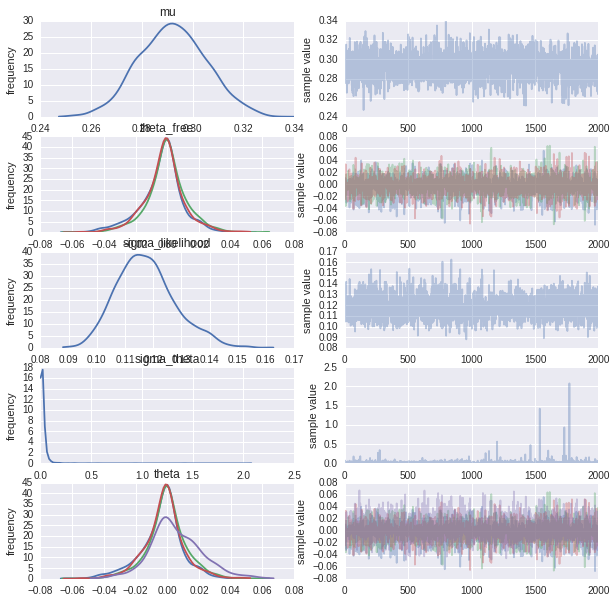

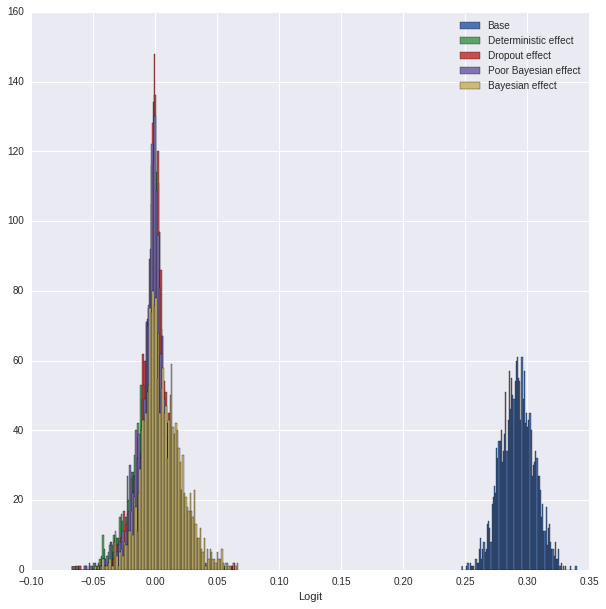

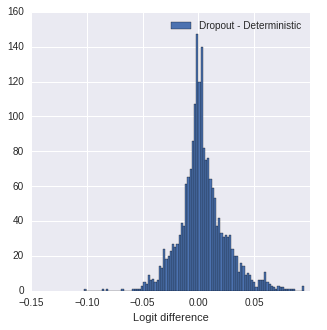

Dropout - Deterministic 95.0 CI: -0.0368514556771 0.0560526294086 Pr > 0: 0.554


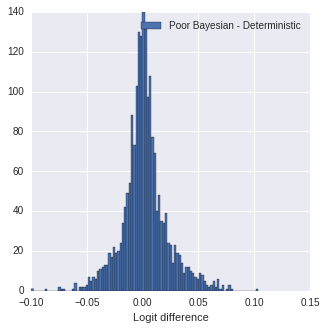

Poor Bayesian - Deterministic 95.0 CI: -0.0399988774623 0.0513635819956 Pr > 0: 0.531


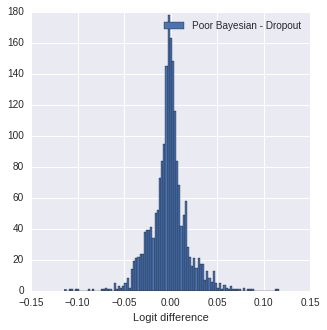

Poor Bayesian - Dropout 95.0 CI: -0.0413040202836 0.0432682582704 Pr > 0: 0.4445


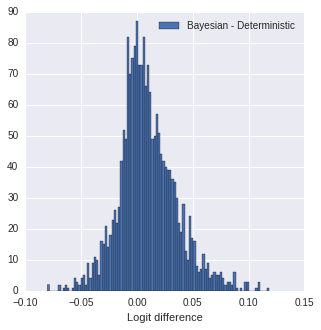

Bayesian - Deterministic 95.0 CI: -0.0389230806759 0.0699983365179 Pr > 0: 0.6265


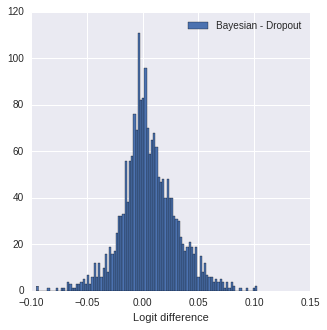

Bayesian - Dropout 95.0 CI: -0.0438689179722 0.0591790012291 Pr > 0: 0.5735


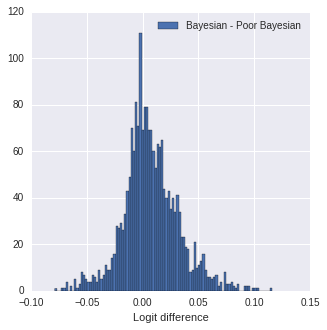

Bayesian - Poor Bayesian 95.0 CI: -0.0443096983875 0.0642565056284 Pr > 0: 0.5975


In [38]:
print(fit)
fit.plot()
trace = fit.extract()

deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]
bayesian = trace['theta'][:,3]

plt.figure()
plt.hist(trace['mu'], bins = 100, label = 'Base')
plt.hist(deterministic, bins = 100, label = 'Deterministic effect')
plt.hist(dropout, bins = 100, label = 'Dropout effect')
plt.hist(poor_bayesian, bins = 100, label = 'Poor Bayesian effect')
plt.hist(bayesian, bins = 100, label = 'Bayesian effect')
plt.legend()
plt.xlabel("Logit")
plt.show()

def effect_difference(effect1, effect2, name1, name2, CI = 95.0):
    diff = effect1 - effect2
    label = str(name1) + ' - ' + str(name2)
    plt.figure(figsize=(5,5))
    plt.hist(diff, bins = 100, label = label)
    plt.legend()
    plt.xlabel("Logit difference")
    plt.show()
    low_p = (100.0 - CI)/2.0
    high_p = low_p + CI
    print(label, str(CI) + ' CI:', np.percentile(diff, low_p), np.percentile(diff, high_p), 'Pr > 0:', (diff > 0).mean())

effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')
effect_difference(bayesian, deterministic, 'Bayesian', 'Deterministic')
effect_difference(bayesian, dropout, 'Bayesian', 'Dropout')
effect_difference(bayesian, poor_bayesian, 'Bayesian', 'Poor Bayesian')